In [180]:
import jax
import jax.numpy as jnp
from jax import grad,jacfwd, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random
from jax import jacfwd
from jax import lax

import sys
import os
import time

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from neural_net import create_train_state, train, neural_ode
from collocation import compute_weights, lagrange_derivative

In [161]:
#-----------------------------------------------DATA GENERATION-----------------------------------------------#
N = 50
noise_level = 0.0
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

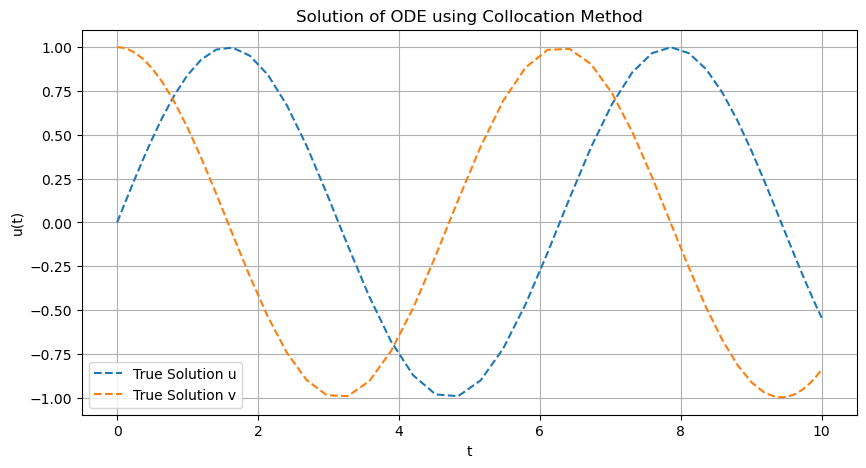

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(t, y.T[0], "--", label='True Solution u')
plt.plot(t, y.T[1], "--", label='True Solution v')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution of ODE using Collocation Method')
plt.legend()
plt.grid()
plt.show()

In [163]:
L = jnp.eye(N)
weights = compute_weights(t)
L_prime = lagrange_derivative(t, weights)
omega = params['omega_squared']

# RHS and G functions
def RHS(u, t, L, apply_fn, params):
    def F_i(i):
        sum_term = jnp.dot(L[i], u)  # Lagrange interpolation
        return apply_fn({'params': params}, sum_term)
    
    F_vec = vmap(F_i)(jnp.arange(len(t)))
    return F_vec

def G(u, t, L, L_prime, RHS, ode_func, params):
    return jnp.dot(L_prime, u) - RHS(u, t, L, ode_func, params)

In [205]:
def loss_fn(u, t, L, L_prime, RHS, apply_fn, params, u_init):
    # include the initial conditions
    u_full = jnp.vstack([u_init[0:1], u])
    # form the residual vector
    G_val = G(u_full, t, L, L_prime, RHS, apply_fn, params)
    # exclude the initial conditions
    return G_val[1:].flatten()

def newton_solve(u_init, t, L, L_prime, RHS, apply_fn, params, tol=1e-6, max_iter=100):
    u = u_init[1:]  # exclude the initial conditions

    for i in range(max_iter):
        G_val = loss_fn(u, t, L, L_prime, RHS, apply_fn, params, u_init)
        J = jacfwd(loss_fn, argnums=0)(u, t, L, L_prime, RHS, apply_fn, params, u_init)

        J = J.reshape((-1, (len(t) - 1) * 2))
        G_val = G_val.reshape((-1, 1))

        delta_u = jnp.linalg.solve(J, -G_val).reshape(u.shape)
        u = u + delta_u

        if jnp.linalg.norm(delta_u) < tol:
            # print(f"Converged at iteration {i + 1} with step norm {jnp.linalg.norm(delta_u)}")
            return jnp.vstack([u_init[0:1], u])  # Reinsert the fixed initial value

    raise ValueError("Newton's method did not converge")

#### this version works with @jit 

In [197]:
def newton_solve(u_init, t, L, L_prime, RHS, apply_fn, params, tol=1e-6, max_iter=100):
    def body_fn(carry, _):
        u, prev_delta_norm = carry
        G_val = loss_fn(u, t, L, L_prime, RHS, apply_fn, params, u_init)
        J = jacfwd(loss_fn, argnums=0)(u, t, L, L_prime, RHS, apply_fn, params, u_init)

        J = J.reshape((G_val.size, -1))
        G_val = G_val.flatten()

        delta_u = jnp.linalg.solve(J, -G_val).reshape(u.shape)
        u = u + delta_u

        delta_norm = jnp.linalg.norm(delta_u)
        return (u, delta_norm), None

    def cond_fn(carry):
        _, delta_norm = carry
        return delta_norm >= tol

    init_val = (u_init[1:], float('inf'))
    final_carry, _ = lax.scan(body_fn, init_val, None, length=max_iter)
    final_u, final_delta_norm = final_carry
    
    return jnp.vstack([u_init[0:1], final_u])

In [209]:
# Define the neural network model using Flax
class NeuralODE(nn.Module):
    layer_widths: list

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layer_widths[-1])(x)
        return x

def create_train_state(rng, layer_widths, learning_rate):
    model = NeuralODE(layer_widths=layer_widths)
    params = model.init(rng, jnp.ones((2,)))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def neural_net_loss(params, apply_fn, u_init, t, L, L_prime, y_true):
    u_solved = newton_solve(u_init, t, L, L_prime, RHS, apply_fn, params)
    return jnp.mean((u_solved - y_true) ** 2)

#@jax.jit
def train_step(state, u_init, t, L, L_prime, y_true):
    def loss(params):
        return neural_net_loss(params, state.apply_fn, u_init, t, L, L_prime, y_true)
    
    grads = grad(loss)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

def train(state, u_init, t, L, L_prime, y_true, num_epochs=1000):
    for epoch in range(num_epochs):
        state = train_step(state, u_init, t, L, L_prime, y_true)
        if epoch % 100 == 0:
            current_loss = neural_net_loss(state.params, state.apply_fn, u_init, t, L, L_prime, y_true)
            print(f"Epoch {epoch}, Loss: {current_loss}")
    return state

In [210]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [211]:
key = random.PRNGKey(0)
layer_widths = [2, 50, 50,2]  # Input layer, hidden layer, output layer
state = create_train_state(key, layer_widths, learning_rate=1e-3)

y_init = estimated_solution.T
y_init = y_init.at[0, 0].set(0.0)
y_init = y_init.at[0, 1].set(1.0)

# Train the neural ODE
trained_state = train(state, y_init, t, L, L_prime, y_noisy, num_epochs=1000)
print("Training completed.")

Epoch 0, Loss: 0.452292736027181
Epoch 100, Loss: 0.34726571949533425
Epoch 200, Loss: 0.3466937082610238
Epoch 300, Loss: 0.36300681927416073
Epoch 400, Loss: 0.33351728074241843
Epoch 500, Loss: 0.3483464916916014
Epoch 600, Loss: 0.34270780590608835
Epoch 700, Loss: 0.33012527815032117
Epoch 800, Loss: 0.352865783157966
Epoch 900, Loss: 0.34677144880332783
Training completed.


In [142]:
def predict(state, u_init, t, L, L_prime):
    params = state.params
    u_solved = newton_solve(u_init, t, L, L_prime, RHS, state.apply_fn, params)
    return u_solved

In [143]:
predictions = predict(trained_state, y_init, t, L, L_prime)

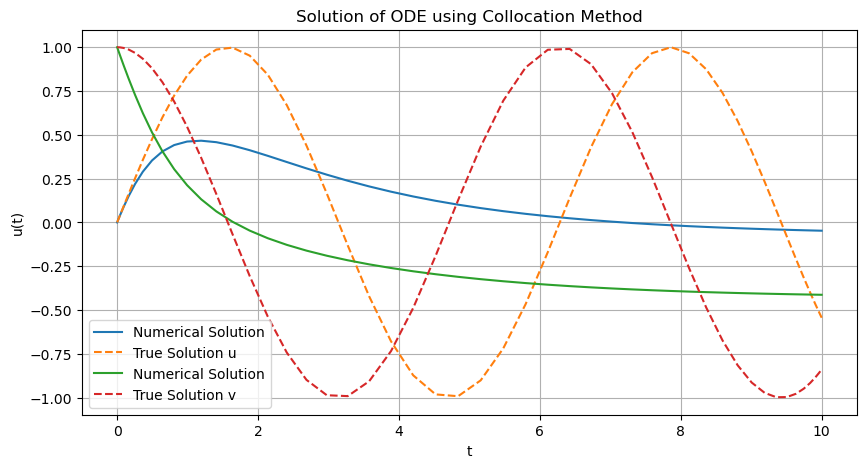

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(t, predictions.T[0], label='Numerical Solution')
plt.plot(t, y.T[0], "--", label='True Solution u')
plt.plot(t, predictions.T[1], label='Numerical Solution')
plt.plot(t, y.T[1], "--", label='True Solution v')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution of ODE using Collocation Method')
plt.legend()
plt.grid()
plt.show()